# Predicting House Value in Boston

## 1. Introduction

## 2. Exploratory Data Analysis

In [98]:
options(repr.plot.width=8, repr.plot.height=6)
library(broom)
library(tidyverse)
library(infer)
library(repr)
library(digest)
library(gridExtra)
library(faraway)
library(mltools)
library(leaps)
library(glmnet)
library(cowplot)
library(AER)
library(GGally)

Reading dataset and assigning names to each column

In [99]:
boston_data <-read_tsv("dataset.txt",
                      col_names=FALSE) %>%
    separate(col=X1,
             into=c("CRIM","ZN","INDUS","CHAS","NOX","RM","AGE","DIS","RAD","TAX","PTRATIO","LSTAT","MEDV"),
             sep="  ") %>%
    separate(col=PTRATIO,
             into=c("PTRATIO","B"),
             sep=" ") %>%
    mutate_if(is.character,as.numeric) 

head(boston_data)

Rows: 506 Columns: 1
── Column specification ────────────────────────────────────────────────────────
Delimiter: "\t"
chr (1): X1

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Warning message:
“Expected 13 pieces. Additional pieces discarded in 24 rows [103, 156, 157, 417, 420, 424, 425, 426, 427, 428, 429, 430, 431, 432, 433, 437, 439, 446, 451, 455, ...].”
Warning message:
“Expected 13 pieces. Missing pieces filled with `NA` in 42 rows [9, 24, 32, 58, 142, 143, 144, 146, 147, 152, 159, 160, 210, 259, 260, 352, 353, 354, 355, 356, ...].”
Warning message:
“Expected 2 pieces. Missing pieces filled with `NA` in 59 rows [9, 24, 32, 103, 142, 143, 144, 146, 147, 152, 156, 157, 210, 368, 374, 375, 380, 383, 384, 387, ...].”
Warning message in mask$eval_all_mutate(quo):
“NAs introduced by coercion”
Warning message in mask$eval_all_mutate(quo):
“NAs introduced by coercion”
Warning mess

CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
0.00632,18,2.31,0,0.538,6.575,65.2,4.0900,1,296,15.3,396.90,4.98,24.0
0.02731,0,7.07,0,0.469,6.421,78.9,4.9671,2,242,17.8,396.90,9.14,21.6
0.02729,0,7.07,0,0.469,7.185,61.1,4.9671,2,242,17.8,392.83,4.03,34.7
0.03237,0,2.18,0,0.458,6.998,45.8,6.0622,3,222,18.7,394.63,2.94,33.4
0.06905,0,2.18,0,0.458,7.147,54.2,6.0622,3,222,18.7,396.90,5.33,36.2
0.02985,0,2.18,0,0.458,6.430,58.7,6.0622,3,222,18.7,394.12,5.21,28.7


The dataset has missing entries (NA) which we will remove from the dataset

In [100]:
boston_data <- na.omit(boston_data)

## 3. Method

Splitting dataset into training and testing datasets (70/30 split)

In [101]:
# Split data into training and test sets
set.seed(123)

boston_data$ID <- rownames(boston_data)

training_boston <- sample_n(boston_data, size = nrow(boston_data) * 0.70,
  replace = FALSE
)

testing_boston <- anti_join(boston_data,
  training_boston,
  by = "ID"
)

# Remove variable "ID"
training_boston <- training_boston  %>% select(-ID)
testing_boston <- testing_boston  %>% select(-ID)

### Full OLS

Using `lm` to build a full regression model (including all explanatory variables)

In [102]:
boston_OLS <- lm(MEDV ~ ., data = training_boston)

Using OLS model to get fitted values on test set

In [103]:
boston_test_OLS <- predict(boston_OLS, testing_boston)

Computing out-of-sample error (RMSE)

In [104]:
boston_OLS_MSE <- tibble(
    Model = "OLS Full Regression",
    R_MSE = rmse(
      preds = boston_test_OLS,
      actuals = testing_boston$MEDV)
    )

boston_OLS_MSE

Model,R_MSE
<chr>,<dbl>
OLS Full Regression,4.648719


### Forward/Backward Selection

In this section, we will be using the forward and backward selection algorithm to determine which variables to consider in our reduced model. The forward selection algorithm will be used first, then the backward selection algorithm will follow. First, the regsubsets function is used for this process and 13 input variables are used for variable selection. This is because there are 14 variables in the original dataset, but 1 of them is the response variable; thus, we have 14 input variables.

In [105]:
boston_forward_sel <- regsubsets(
  x = MEDV ~ ., 
  nvmax = 13,
  data = training_boston,
  method = "forward",
)

boston_forward_sel <- summary(boston_forward_sel)
boston_forward_sel

Subset selection object
Call: regsubsets.formula(x = MEDV ~ ., nvmax = 13, data = training_boston, 
    method = "forward", )
13 Variables  (and intercept)
        Forced in Forced out
CRIM        FALSE      FALSE
ZN          FALSE      FALSE
INDUS       FALSE      FALSE
CHAS        FALSE      FALSE
NOX         FALSE      FALSE
RM          FALSE      FALSE
AGE         FALSE      FALSE
DIS         FALSE      FALSE
RAD         FALSE      FALSE
TAX         FALSE      FALSE
PTRATIO     FALSE      FALSE
B           FALSE      FALSE
LSTAT       FALSE      FALSE
1 subsets of each size up to 13
Selection Algorithm: forward
          CRIM ZN  INDUS CHAS NOX RM  AGE DIS RAD TAX PTRATIO B   LSTAT
1  ( 1 )  " "  " " " "   " "  " " "*" " " " " " " " " " "     " " " "  
2  ( 1 )  " "  " " " "   " "  " " "*" " " " " " " " " " "     " " "*"  
3  ( 1 )  " "  " " " "   " "  " " "*" " " " " " " " " "*"     " " "*"  
4  ( 1 )  " "  " " " "   "*"  " " "*" " " " " " " " " "*"     " " "*"  
5  ( 1 )  " "  " 

The Cp for each number of variables is compared in the table below. By doing this, the optimal Cp value can be obtained and be used in the reduced model. From the table, below, the optimal number of variables is 10, since it has the lowest CP value. The variables selected for the reduced model are CRIM, CHAS, NOX, RM, AGE, DIS, RAD, TAX, PTRATIO, LSTAT.

In [106]:
boston_forward_df <- tibble(
    n_input_variables = 1:13,
    Cp = boston_forward_sel$cp
)
boston_forward_df

n_input_variables,Cp
<int>,<dbl>
1,245.079425
2,110.688645
3,50.951415
4,30.410363
5,25.654981
6,16.001326
7,11.522293
8,9.661386
9,10.562568


From here, a linear model is fit with the 10 chosen varaibles. Then a prediction is made reduced linear model and the testing set. Finally, the root mean squared error is calculated through the reduced OLS model.

In [107]:
boston_red_OLS_for <- lm(MEDV~CRIM+CHAS+NOX+RM+AGE+DIS+RAD+TAX+PTRATIO+LSTAT,
  data = training_boston
)
boston_pred_red_OLS_for <- predict(boston_red_OLS_for, testing_boston)

In [108]:
boston_R_MSE_forward <- tibble(
    Model = "OLS Reduced Regression Forward",
    R_MSE = rmse(
        preds = boston_pred_red_OLS_for,
        actuals = testing_boston$MEDV
        )
    )
boston_R_MSE_forward

Model,R_MSE
<chr>,<dbl>
OLS Reduced Regression Forward,4.671525


Now the backward selection algorithm will be used. The code is very similar to the forward selection algorithm's code; however, this algorithm starts with all of the variables, and removes some of them from the full model to create the reduced model.

In [109]:
boston_backward_sel <- regsubsets(
  x = MEDV ~., 
  nvmax=13,
  data=training_boston,
  method="backward"
)

boston_backward_sel <- summary(boston_backward_sel)
boston_backward_sel

Subset selection object
Call: regsubsets.formula(x = MEDV ~ ., nvmax = 13, data = training_boston, 
    method = "backward")
13 Variables  (and intercept)
        Forced in Forced out
CRIM        FALSE      FALSE
ZN          FALSE      FALSE
INDUS       FALSE      FALSE
CHAS        FALSE      FALSE
NOX         FALSE      FALSE
RM          FALSE      FALSE
AGE         FALSE      FALSE
DIS         FALSE      FALSE
RAD         FALSE      FALSE
TAX         FALSE      FALSE
PTRATIO     FALSE      FALSE
B           FALSE      FALSE
LSTAT       FALSE      FALSE
1 subsets of each size up to 13
Selection Algorithm: backward
          CRIM ZN  INDUS CHAS NOX RM  AGE DIS RAD TAX PTRATIO B   LSTAT
1  ( 1 )  " "  " " " "   " "  " " "*" " " " " " " " " " "     " " " "  
2  ( 1 )  " "  " " " "   " "  " " "*" " " " " " " " " " "     " " "*"  
3  ( 1 )  " "  " " " "   " "  " " "*" " " " " " " " " "*"     " " "*"  
4  ( 1 )  " "  " " " "   "*"  " " "*" " " " " " " " " "*"     " " "*"  
5  ( 1 )  " "  " 

The Cp values are compared in a table with the number of input variables. Similar to the foward selection algorithm, the optimal number of input variables is 10 because the Cp value is the lowest. The variables that will be used are CRIM, CHAS, NOX, RM, AGE, DIS, RAD, TAX, PTRATIO, LSTAT.

In [110]:
boston_backward_df <- tibble(
    n_input_variables = 1:13,
    Cp = boston_backward_sel$cp
)
boston_backward_df

n_input_variables,Cp
<int>,<dbl>
1,245.07942
2,110.68865
3,50.95141
4,30.41036
5,25.65498
6,16.94133
7,11.11134
8,10.83908
9,10.02018


After determining the optimal number of variables through the backward selection algorithm, we can fit a linear model with the selected variables. Then we can predict with the reduced model and the testing set.

In [111]:
boston_red_OLS_bac <- lm(MEDV~CRIM+CHAS+NOX+RM+AGE+DIS+RAD+TAX+PTRATIO+LSTAT,
  data = training_boston
)
boston_pred_red_OLS_bac <- predict(boston_red_OLS_bac, testing_boston)


Then we can compute the RMSE for the reduced model.

In [112]:
boston_R_MSE_backward <- tibble(
    Model = "OLS Reduced Regression Backward",
    R_MSE = rmse(
        preds = boston_pred_red_OLS_bac,
        actuals = testing_boston$MEDV
        )
    )
boston_R_MSE_backward

Model,R_MSE
<chr>,<dbl>
OLS Reduced Regression Backward,4.671525


### Variable Selection using LASSO 

Building matrix and vector using training set (training_boston) as it is required by `glmnet`

In [113]:
boston_X_train <- training_boston %>% select(-MEDV) %>% as.matrix()
boston_Y_train <- training_boston %>% select(MEDV) %>% as.matrix()

boston_X_test <- testing_boston %>% select(-MEDV) %>% as.matrix()
boston_Y_test <- testing_boston %>% select(MEDV) %>% as.matrix()

Using `cv.glmnet` to do cross validation to find the best lambda ($\lambda$)

In [114]:
lasso_cv <-
    cv.glmnet(boston_X_train, 
              boston_Y_train, 
              alpha = 1)

lasso_cv


Call:  cv.glmnet(x = boston_X_train, y = boston_Y_train, alpha = 1) 

Measure: Mean-Squared Error 

    Lambda Index Measure    SE Nonzero
min 0.0118    69   18.35 3.347      13
1se 0.9331    22   21.62 3.246       4

Plot: CV Mean square error (MSE) over a range of $\log(\lambda)$ values

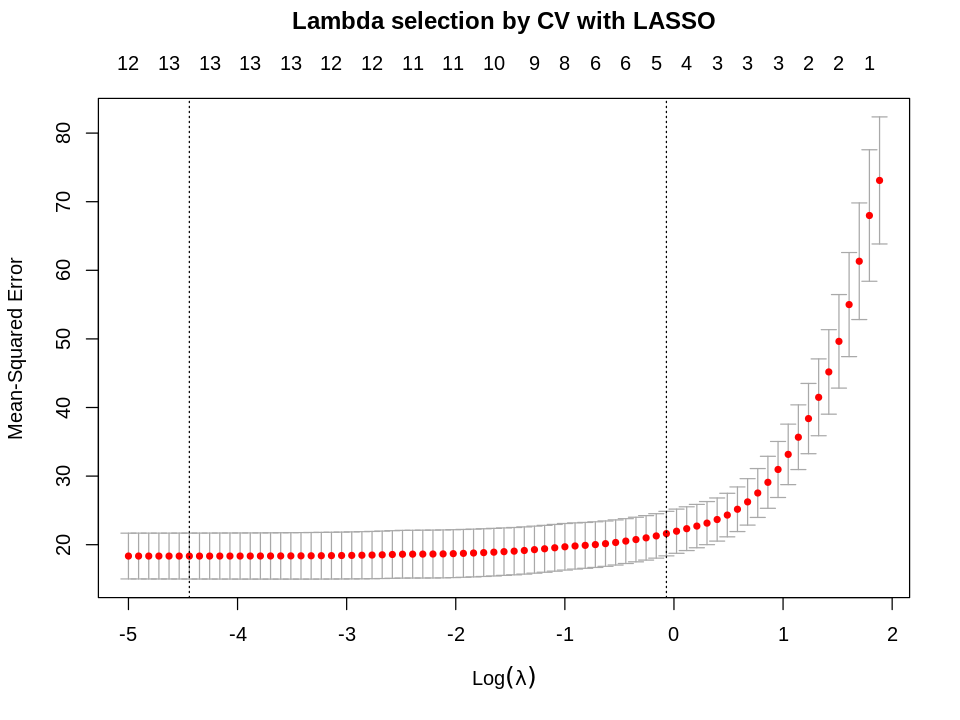

In [116]:
plot(lasso_cv, main = "Lambda selection by CV with LASSO\n\n")

Obtaining $\lambda$ that minimizes MSE ($\lambda_{min}$) and the largest $\lambda$ such that it is within one standard error of the minimum MSE ($\lambda_{1se}$).

In [118]:
lambda_min <- lasso_cv$lambda.min
lambda_1se <- lasso_cv$lambda.1se

Plot: Estimated regression coefficients over the $\lambda$-grid where the vertical red line is $\log(\lambda_{min})$ and the blue line is $\log(\lambda_{1se})$

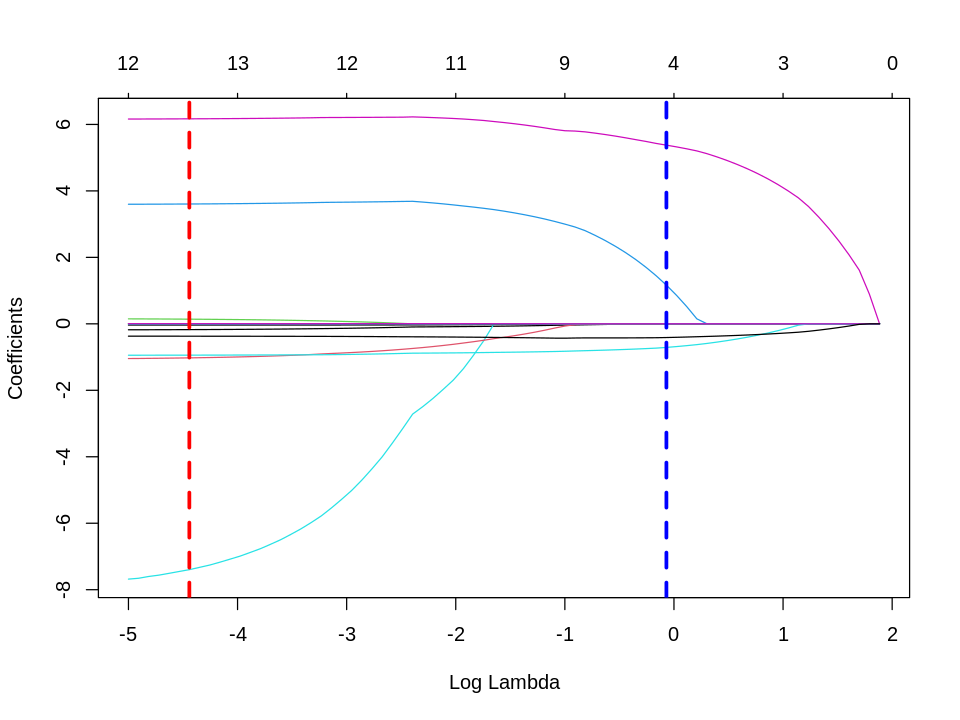

In [120]:
plot(lasso_cv$glmnet.fit, "lambda")
abline(v = log(lambda_min), col = "red", lwd = 3, lty = 2)
abline(v = log(lambda_1se), col = "blue", lwd = 3, lty = 2)

Fitting lasso model using $\lambda_{min}$ and $\lambda_{1se}$

In [93]:
# Using lambda.min
boston_LASSO_min <- glmnet(
  x = boston_X_train, y = boston_Y_train,
  alpha = 1,
  lambda = lambda_min
)

boston_LASSO_1se <- glmnet(
  x = boston_X_train, y = boston_Y_train,
  alpha = 1,
  lambda = lambda_1se
)

ERROR: Error in glmnet(x = boston_X_train, y = boston_Y_train, alpha = 1, lambda = lambda_min): object 'lambda_min' not found


Using `predict` to get fitted values of test set using our Lasso models

In [94]:
boston_test_LASSO_min <- predict(boston_LASSO_min,
  newx = boston_X_test)

boston_test_LASSO_1se <- predict(boston_LASSO_1se,
  newx = boston_X_test)

ERROR: Error in predict(boston_LASSO_min, newx = boston_X_test): object 'boston_LASSO_min' not found


Calculating out-of-sample error (RMSE)

In [95]:
boston_LASSO_MSE <- rbind(boston_OLS_MSE, 
                          boston_R_MSE_forward, 
                          boston_R_MSE_backward,
    tibble(
    Model = "LASSO Regression with minimum MSE",
    R_MSE = rmse(
      preds = boston_test_LASSO_min,
      actuals = testing_boston$MEDV)
    ), 
    tibble(
    Model = "LASSO Regression with 1 SE of minimum MSE",
    R_MSE = rmse(
      preds = boston_test_LASSO_1se,
      actuals = testing_boston$MEDV)
    )
)
boston_LASSO_MSE

ERROR: Error in rmse(preds = boston_test_LASSO_min, actuals = testing_boston$MEDV): object 'boston_test_LASSO_min' not found
